#### Import Library

In [24]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from skimage.color import lab2rgb, rgb2lab
from skimage import io
from sklearn.metrics import mean_squared_error
from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping
import copy
import time
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import torchvision
import torch.utils.benchmark as benchmark

# Convert to 32-bit float
torch.set_default_tensor_type('torch.FloatTensor')

#### Visualize first image

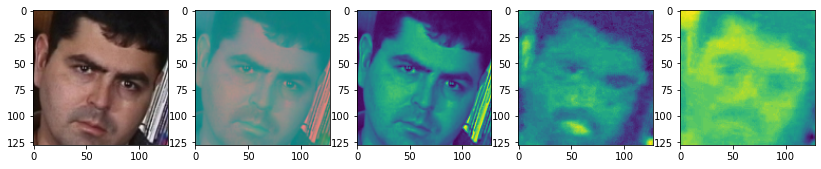

In [25]:
img = cv2.imread("face_images/image00000.jpg")
imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
L,a,b = cv2.split(imageLAB)

plt.figure(figsize=(14,7)) 

plt.subplot(1,5,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

plt.subplot(1,5,2)
plt.imshow(imageLAB)

plt.subplot(1,5,3)
plt.imshow(L)

plt.subplot(1,5,4)
plt.imshow(a)

plt.subplot(1,5,5)
plt.imshow(b)

#### Load Dataset

In [26]:
img_dir = "face_images/"
img_files = img_dir + '*jpg'
files = glob.glob(img_files)
data = []

for f1 in files:
    img = cv2.imread(f1)
    data.append(img)
    
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

final = torch.reshape(x_np,(750,3,128,128))
final.shape

torch.Size([750, 3, 128, 128])

#### Augment Dataset

In [27]:
rand_crop = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomCrop(size=(100,100)),
                                transforms.Resize(size=(128,128))])

hori_flip = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(p=1)])

ver_flip = transforms.Compose([transforms.ToPILImage(),
                               transforms.RandomVerticalFlip(p=1)])

rotate = transforms.Compose([transforms.ToPILImage(),
                             transforms.RandomRotation(degrees=(-60,60))])

sharp = transforms.Compose([transforms.ToPILImage(),
                            transforms.RandomAdjustSharpness(sharpness_factor=1.5)])

#### Applying augment transform and saving in folder

In [28]:
img_dir = "face_images/"
aug_dir = 'augmented/'
test_dir = 'test_folder/'
img_files = img_dir + '*jpg'
files = glob.glob(img_files)

os.makedirs(aug_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for i, f1 in enumerate(files):
    image = cv2.imread(f1)
    if(i<675):   
        cv2.imwrite((f1.replace(img_dir,aug_dir).replace('.jpg', '_orig.jpg')), image)
        cv2.imwrite((f1.replace(img_dir,aug_dir).replace('.jpg', '_hor.jpg')), np.asarray(hori_flip(image)))
        cv2.imwrite((f1.replace(img_dir,aug_dir).replace('.jpg', '_vert.jpg')), np.asarray(ver_flip(image)))
        cv2.imwrite((f1.replace(img_dir,aug_dir).replace('.jpg', '_rot.jpg')), np.asarray(rotate(image)))
        cv2.imwrite((f1.replace(img_dir,aug_dir).replace('.jpg', '_crop.jpg')), np.asarray(sharp(image)))
    else:
        cv2.imwrite(f1.replace(img_dir,test_dir), image)

#### Conversion to L,a,b color space and saving in folder

In [29]:
os.makedirs('L', exist_ok=True)
os.makedirs('a', exist_ok=True)
os.makedirs('b', exist_ok=True)

aug_files = aug_dir + '*jpg'
files = glob.glob(aug_files)

for f1 in files:
    name = f1.replace("augmented/","")
    img = cv2.imread(f1)
    imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L,a,b = cv2.split(imageLAB)

    cv2.imwrite('L/'+ name, L)
    cv2.imwrite('a/'+ name, a)
    cv2.imwrite('b/'+ name, b)

#### Building Regressor

In [30]:
class img_reg(nn.Module):
    def __init__(self, input_channels = 1, hidden_channels = 3, out_channels = 2):
        super(img_reg,self).__init__()
        self.features = nn.Sequential(
                                nn.Conv2d(input_channels, 32, 4, 2, 1),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(),

                                nn.Conv2d(32, 64, 4, 2, 1),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(),

                                nn.Conv2d(64, 128, 4, 2, 1),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU(),

                                nn.Conv2d(128, 256, 4, 2, 1),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(),
            
                                nn.Conv2d(256, 256, 4, 2, 1),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(),

                                nn.Conv2d(256, 512, 4, 2, 1),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU(),
                               )
        self.linear = nn.Linear(512*2*2, 2)
        
    def forward(self, x):
        features = self.features(x) 
        linear = torch.sigmoid(self.linear(features.reshape(-1, 512 * 2 * 2)))
        return linear

#### GPU Loading

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available()else  "cpu")
is_cuda_available = True if torch.cuda.is_available() else False
if is_cuda_available:
    num_workers = 4
else:
    num_workers = 0
print(format(device))

cuda:0


#### Class for Image conversion to LAB

In [32]:
class ImagetoLAB(Dataset):
    def __init__(self, root_dir, transform, regressor_only):
        image_paths = os.listdir(root_dir)
        image_paths = [image_path for image_path in image_paths if image_path.endswith('.jpg')]
        random.shuffle(image_paths)
        
        self.image_paths = np.array(image_paths)
        self.root_dir = root_dir
        self.transform = transform
        self.regressor_only = regressor_only

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (None, None, None)
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

        if self.transform:
            image_lab = self.transform(image)
            image_gray = image_lab[0:1,:,:]

            if self.regressor_only:
                image_a = image_lab[1:2, :, :]
                image_b = image_lab[2:3, :, :]
                sample = (image_gray, image_a, image_b)
            else:
                image_ab = self.transform(image)[1:,:,:]
                sample = (image_gray, image_lab, image_ab)
        return sample

#### Transform Image to LAB and tensors & load into dataloader

In [33]:
transform = transforms.Compose([transforms.ToTensor()])

transform_train = ImagetoLAB(root_dir = aug_dir,
                                          transform=transform,
                                          regressor_only=True)
transform_test = ImagetoLAB(root_dir = test_dir,
                                         transform=transform,
                                         regressor_only=True)


train_loader = DataLoader(transform_train, batch_size=8, shuffle=True)
test_loader = DataLoader(transform_test, batch_size=8, shuffle=False)

print(train_loader)

In [34]:
def ab_mean(a, b):
    a_mean = a.mean(dim=(2, 3))
    b_mean = b.mean(dim=(2, 3))
    a_b_mean = torch.cat([a_mean, b_mean], dim=1)
    return a_b_mean

#### Training Regressor

In [35]:
class Reg_train_test:
    def train(self, train_loader, device, epochs=200):
        model = img_reg(input_channels = 1, hidden_channels = 3, out_channels = 2).to(device)

        lossF = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        loss_train = []

        for epoch in range(epochs):
            total_loss = 0
            model.train()

            for batch in train_loader:
                l_channel, a_channel, b_channel = batch
                l_channel = l_channel.to(device)

                a_b_mean = ab_mean(a_channel, b_channel)
                a_b_mean_hat = model(l_channel)

                if torch.cuda.is_available():
                    loss = lossF(a_b_mean_hat.float().cuda(),
                                 a_b_mean.float().cuda()).to(device)
                else:
                    loss = lossF(a_b_mean_hat.float(),
                                 a_b_mean.float()).to(device)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print("Epoch - {0}, Loss - {1}".format(epoch, total_loss))
            loss_train.append(total_loss)
        
        plt.ion()
        fig = plt.figure()
        plt.plot(loss_train)
        plt.xlabel('Number of Epochs')
        plt.ylabel('Loss')
        plt.draw()
        plt.savefig('Epoch_loss_regressor.jpg', dpi=200)
        plt.clf()
        
        torch.save(model.state_dict(), 'regressor.pth')

    def test(self, test_loader, device):
        model = img_reg(input_channels = 1, hidden_channels = 3, out_channels = 2).to(device)
        model.load_state_dict(torch.load('regressor.pth', map_location=device))

        a_list = []
        b_list = []
        og_list_a = []
        og_list_b = []
        lossF = nn.MSELoss()
        total_loss = 0
        loss_train = []
        for batch in test_loader:
            l_channel, a_channel, b_channel = batch
            l_channel = l_channel.to(device)

            a_b_mean = ab_mean(a_channel, b_channel)
            a_b_mean_hat = model(l_channel).detach()
           
            if torch.cuda.is_available():
                loss = lossF(a_b_mean_hat.float().cuda(),
                             a_b_mean.float().cuda()).to(device)
            else:
                loss = lossF(a_b_mean_hat.float(),
                             a_b_mean.float()).to(device)

            loss_train.append(loss.item())

            a_b_pred = a_b_mean_hat[0].cpu().numpy()
            a_list.append(a_b_pred[0])
            b_list.append(a_b_pred[1])
            
            og_list_a.append(a_channel.mean())
            og_list_b.append(b_channel.mean())

        print("MSE is", np.average(np.asarray(loss_train)))
        for i in range(1, len(a_list)):
            print("Image - {0} | mean a - {1} | mean b - {2}".format(i, (a_list[i] * 255) - 128, (b_list[i] * 255) - 128))
            
        return mean_squared_error(og_list_a, a_list), mean_squared_error(og_list_b, b_list)

#### GPU vs CPU Evaluation for 5 epochs

In [38]:
t0 = benchmark.Timer(stmt='reg_obj.train(train_loader,device,epochs)',
                    setup='from __main__ import reg_obj',
                    globals={'train_loader': train_loader, 'device':"cuda:0", 'epochs':5})

t1 = benchmark.Timer(stmt='reg_obj.train(train_loader,device,epochs)',
                    setup='from __main__ import reg_obj',
                    globals={'train_loader': train_loader, 'device':"cpu", 'epochs':5})

print('GPU',t0.timeit(1))
print('CPU',t1.timeit(1))

Epoch - 0, Loss - 2.82422492018668
Epoch - 1, Loss - 0.21029057737905532
Epoch - 2, Loss - 0.13811932582393638
Epoch - 3, Loss - 0.10707264216034673
Epoch - 4, Loss - 0.08689199680884485
Epoch - 0, Loss - 1.73661061108578
Epoch - 1, Loss - 0.2178093551992788
Epoch - 2, Loss - 0.1191111058142269
Epoch - 3, Loss - 0.08838314727108809
Epoch - 4, Loss - 0.07583659657029784
Epoch - 0, Loss - 2.7954195449419785
Epoch - 1, Loss - 0.1789617501126486
Epoch - 2, Loss - 0.13066948142659385
Epoch - 3, Loss - 0.08820610554539599
Epoch - 4, Loss - 0.07406491469191678
GPU <torch.utils.benchmark.utils.common.Measurement object at 0x2ae603c975e0>
reg_obj.train(train_loader,device,epochs)
setup: from __main__ import reg_obj
  26.78 s
  1 measurement, 1 runs , 1 thread
Epoch - 0, Loss - 3.083656669659831
Epoch - 1, Loss - 0.21263255405574455
Epoch - 2, Loss - 0.09445296912599588
Epoch - 3, Loss - 0.07779424428008497
Epoch - 4, Loss - 0.07217718772153603
Epoch - 0, Loss - 3.4113314442511182
Epoch - 1, Los

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

#### Training on GPU

In [39]:
reg_obj = Reg_train_test()
reg_obj.train(train_loader,device,epochs=100)

Epoch - 0, Loss - 3.0020528210370685
Epoch - 1, Loss - 0.22417343682900537
Epoch - 2, Loss - 0.13356709887011675
Epoch - 3, Loss - 0.10396501842842554
Epoch - 4, Loss - 0.07995958260289626
Epoch - 5, Loss - 0.07008500424126396
Epoch - 6, Loss - 0.06377827100732247
Epoch - 7, Loss - 0.06204936675567296
Epoch - 8, Loss - 0.05988384697229776
Epoch - 9, Loss - 0.05979549468247569
Epoch - 10, Loss - 0.05844760494801449
Epoch - 11, Loss - 0.058413848839336424
Epoch - 12, Loss - 0.05872638284563436
Epoch - 13, Loss - 0.058858443084318424
Epoch - 14, Loss - 0.05747147353213222
Epoch - 15, Loss - 0.05683370380756969
Epoch - 16, Loss - 0.05669264999596635
Epoch - 17, Loss - 0.05559334177269193
Epoch - 18, Loss - 0.05612944944550691
Epoch - 19, Loss - 0.055308323422650574
Epoch - 20, Loss - 0.05689062200508488
Epoch - 21, Loss - 0.056511124146709335
Epoch - 22, Loss - 0.0557502944720909
Epoch - 23, Loss - 0.0639525071492244
Epoch - 24, Loss - 0.06588617858869839
Epoch - 25, Loss - 0.0656140200972

<Figure size 432x288 with 0 Axes>

In [40]:
mse_a, mse_b = reg_obj.test(test_loader,device)

print('The mean square error for channel a is',mse_a)
print('The mean square error for channel b is',mse_b)

MSE is 0.00016642018381389788
Image - 1 | mean a - 11.886484146118164 | mean b - 11.09668892621994
Image - 2 | mean a - 11.886484146118164 | mean b - 11.09668892621994
Image - 3 | mean a - 11.886484146118164 | mean b - 11.09668892621994
Image - 4 | mean a - 11.886484146118164 | mean b - 11.09668892621994
Image - 5 | mean a - 11.886484146118164 | mean b - 11.09668892621994
Image - 6 | mean a - 11.886484146118164 | mean b - 11.09668892621994
Image - 7 | mean a - 11.886484146118164 | mean b - 11.09668892621994
Image - 8 | mean a - 11.886484146118164 | mean b - 11.09668892621994
Image - 9 | mean a - 11.886484146118164 | mean b - 11.09668892621994
The mean square error for channel a is 8.9449695e-06
The mean square error for channel b is 4.1342235e-05


#### Colorization Convolution layer

In [41]:
class colorizer(nn.Module):
    def __init__(self):
        super(colorizer,self).__init__()
        self.downsample = nn.Sequential(
                                    nn.Conv2d(1, 4, 3, 2, 1),
                                    nn.BatchNorm2d(4),
                                    nn.ReLU(),
            
                                    nn.Conv2d(4, 8, 3, 2, 1),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU(),
            
                                    nn.Conv2d(8, 16, 3, 2, 1),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
            
                                    nn.Conv2d(16, 32, 3, 2, 1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
            
                                    nn.Conv2d(32, 64, 3, 2, 1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
            
                                    nn.Conv2d(64, 128, 3, 2, 1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    )
        
        self.upsample = nn.Sequential(
                                    nn.ConvTranspose2d(128, 64, 2, 2),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
            
                                    nn.ConvTranspose2d(64, 32, 2, 2),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
            
                                    nn.ConvTranspose2d(32, 16, 2, 2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
            
                                    nn.ConvTranspose2d(16, 8, 2, 2),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU(),
            
                                    nn.ConvTranspose2d(8, 4, 2, 2),
                                    nn.BatchNorm2d(4),
                                    nn.ReLU(),
            
                                    nn.ConvTranspose2d(4, 2, 2, 2),
                                    nn.Sigmoid()
                                    )

    def forward(self, x):
        down = self.downsample(x)
        output = self.upsample(down)
        return output

#### Colorizer data preprocessing

In [83]:
batch_size=8

transform = transforms.Compose([transforms.ToTensor()])

transform_train = ImagetoLAB(root_dir = aug_dir,
                                          transform=transform,
                                          regressor_only=False)
transform_test = ImagetoLAB(root_dir = test_dir,
                                         transform=transform,
                                         regressor_only=False)


train_loader = DataLoader(transform_train, batch_size=8, shuffle=True)
test_loader = DataLoader(transform_test, batch_size=8, shuffle=False)

print(train_loader)

#### Colorizer Training

In [84]:
#device = "cpu"
device = "cuda:0"

color = colorizer().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(color.parameters(), lr=0.001, weight_decay=1e-4)

epoch_history = {'1': []}
num_mini_batch_print = 50

def train_step(engine, batch):
    
    images_gray, images_color, images_ab = batch[0].to(device), batch[1].to(device), batch[2].to(device)
    optimizer.zero_grad()
    outputs = color(images_gray)
    loss = criterion(outputs, images_ab)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)

def validation_step(engine, batch):
    with torch.no_grad():
        images_gray, images_color, images_ab = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        outputs = color(images_gray)
        return outputs, images_ab

evaluator = Engine(validation_step)
metric = Loss(criterion)
metric.attach(evaluator, 'mse')

@trainer.on(Events.ITERATION_COMPLETED(every=num_mini_batch_print))
def log_training_loss(trainer):
    global epoch_history
    epoch_history[f'{trainer.state.epoch}'].append(trainer.state.output)
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.5f}")
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    global epoch_history
    epoch_history[f'{trainer.state.epoch + 1 }'] = []
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.5f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.5f}")

def score_function(engine):
    val_loss = engine.state.metrics['mse']
    return -val_loss

handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

t0 = time.time()
trainer.run(train_loader, max_epochs=20)
t1 = time.time()

print('Time taken',t1-t0)

Epoch[1] Loss: 0.00259
Epoch[1] Loss: 0.00140
Epoch[1] Loss: 0.00089
Epoch[1] Loss: 0.00055
Epoch[1] Loss: 0.00069
Epoch[1] Loss: 0.00063
Epoch[1] Loss: 0.00049
Epoch[1] Loss: 0.00050
Training Results - Epoch: 1  Avg loss: 0.00053
Validation Results - Epoch: 1  Avg loss: 0.00054
Epoch[2] Loss: 0.00044
Epoch[2] Loss: 0.00041
Epoch[2] Loss: 0.00042
Epoch[2] Loss: 0.00046
Epoch[2] Loss: 0.00045
Epoch[2] Loss: 0.00042
Epoch[2] Loss: 0.00038
Epoch[2] Loss: 0.00050
Training Results - Epoch: 2  Avg loss: 0.00045
Validation Results - Epoch: 2  Avg loss: 0.00045
Epoch[3] Loss: 0.00045
Epoch[3] Loss: 0.00057
Epoch[3] Loss: 0.00040
Epoch[3] Loss: 0.00041
Epoch[3] Loss: 0.00044
Epoch[3] Loss: 0.00041
Epoch[3] Loss: 0.00051
Epoch[3] Loss: 0.00036
Epoch[3] Loss: 0.00035
Training Results - Epoch: 3  Avg loss: 0.00046
Validation Results - Epoch: 3  Avg loss: 0.00045
Epoch[4] Loss: 0.00039
Epoch[4] Loss: 0.00037
Epoch[4] Loss: 0.00045
Epoch[4] Loss: 0.00036
Epoch[4] Loss: 0.00034
Epoch[4] Loss: 0.00053

2022-10-31 20:28:59,887 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
2022-10-31 20:28:59,995 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch: 13  Avg loss: 0.00038
Validation Results - Epoch: 13  Avg loss: 0.00038
Time taken 154.9882984161377


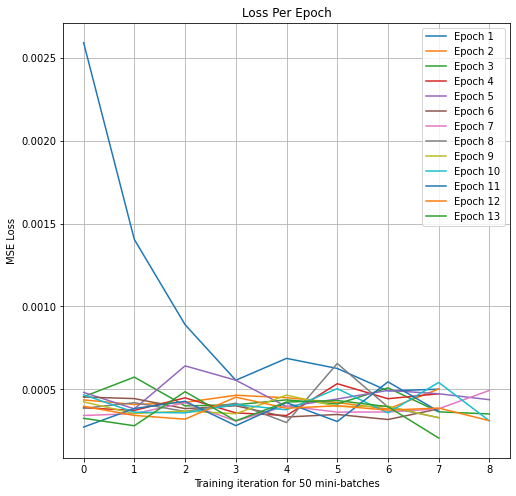

In [85]:
plt.figure(figsize=(8,8))
plt.clf()

for i in range(1, len(epoch_history)):
    plt.plot(range(len(epoch_history[f'{i}'])), epoch_history[f'{i}'], label=f'Epoch {i}')

plt.legend(loc="upper right")
plt.xlabel(f'Training iteration for {num_mini_batch_print} mini-batches')
plt.ylabel('MSE Loss')
plt.title('Loss Per Epoch')
plt.grid(True)
plt.savefig('Epoch_loss_colorizer_face.png')
plt.show()

In [86]:
PATH = './color.pth'
torch.save(color.state_dict(), PATH)

In [87]:
def tensor_to_rgb(tensors):
    images_RGB = []

    for tensor in tensors:
        color_image = tensor.detach().clone().numpy()
        color_image = np.transpose(color_image, (1,2,0))
        color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
        color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
        color_image = lab2rgb(color_image.astype(np.float64))
        color_image = np.transpose(color_image, (2,0,1))
        images_RGB.append(color_image)

    return torch.tensor(np.array(images_RGB))

def cat_l_ab(images_gray, images_ab):
    return torch.cat((images_gray, images_ab), 1)

output_dir = './output_color'

In [88]:
os.makedirs(output_dir,exist_ok=True)
test_loss = []
output_list = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images_gray, images_color, images_ab = data[0].to(device), data[1].to(device), data[2].to(device)
        outputs = color(images_gray)
        outputs_color = cat_l_ab(images_gray, outputs)
        outputs_lab = torch.cat((images_gray, outputs), 1)
        
        rgb_outputs = tensor_to_rgb(outputs_color.cpu())
        
        for j in range(outputs.shape[0]):
            loss = criterion(outputs[j], images_ab[j])
            test_loss.append(loss)

            img_idx = (i * batch_size) + j
            img_path = os.path.join(output_dir, transform_test.image_paths[img_idx])
            img_data = torch.permute(rgb_outputs[j], (1, 2, 0)).numpy()
            output_list.append(img_data)
            io.imsave(img_path, img_data)
            
print('Average test loss is',torch.mean(torch.tensor(test_loss)))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Average test loss is tensor(0.0004)


#### Images Plots for Face Dataset

Target: Original Color Face Image


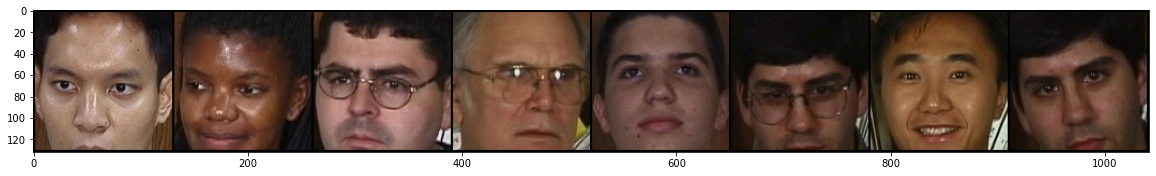

Input Image: Gray Face Image


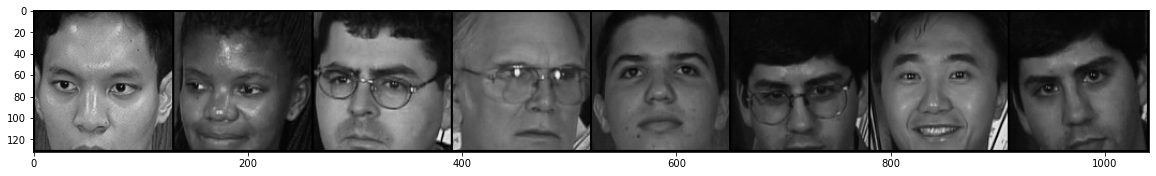

LAB Face Image


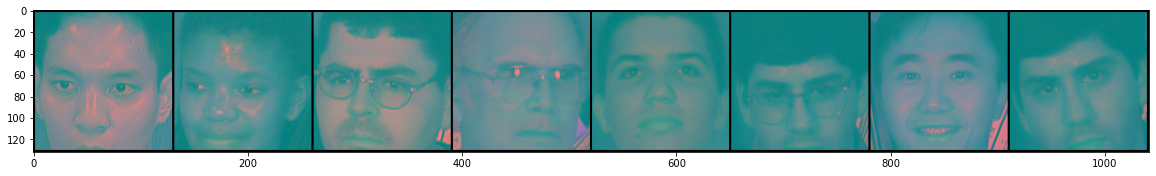

Predicted Colorized Face Image


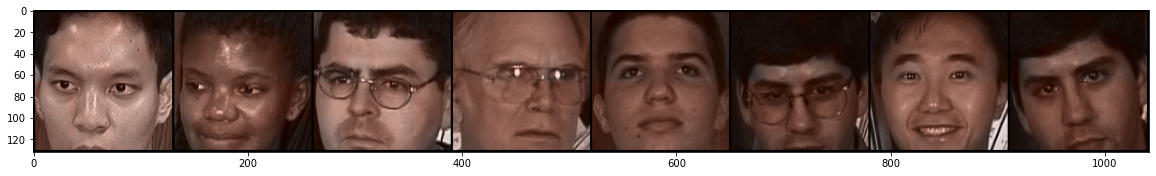

In [89]:
def imshow(img, save_as=''):
    plt.figure(figsize=(20,20))
    plt.clf()
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = npimg.astype('float32')
    plt.imshow(npimg)
    
    if save_as:
        plt.savefig(save_as)
    
    plt.show()

dataiter = iter(test_loader)
images_gray, images_color, images_ab = dataiter.next()

print('Target: Original Color Face Image')
imshow(torchvision.utils.make_grid(tensor_to_rgb(images_color)))

print('Input Image: Gray Face Image')
imshow(torchvision.utils.make_grid(images_gray))

print('LAB Face Image')
imshow(torchvision.utils.make_grid(images_color))

print('Predicted Colorized Face Image')
image_tensor = []
for i in range(8):
    image_tensor.append(transform(output_list[i]))
imshow(torchvision.utils.make_grid(image_tensor))

### Transfer Learning

#### Split ColorfulOriginal Dataset to Train/Test

In [90]:
os.makedirs('color_fruit_train',exist_ok=True)
os.makedirs('color_fruit_test',exist_ok=True)

color_train_dir = 'color_fruit_train'
color_test_dir = 'color_fruit_test'
color_dir = 'ColorfulOriginal/*'
color_folder = 'ColorfulOriginal'
classes = glob.glob(color_dir)
print(classes)
counter_list = []

resize = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(size=(128,128))])
for i in classes:
    t = i.replace('ColorfulOriginal/','')
    class_images  = glob.glob(i+'/*.jpg')
    counter_value = round(len(class_images)*0.8)
    
    for c, file in enumerate(class_images):
        image = cv2.imread(file)
        if(c<counter_value):   
            cv2.imwrite(file.replace(os.path.join(color_folder,t),color_train_dir),  np.asarray(resize(image)))
        else:
            cv2.imwrite(file.replace(os.path.join(color_folder,t),color_test_dir),  np.asarray(resize(image)))

['ColorfulOriginal/Potato', 'ColorfulOriginal/Pear', 'ColorfulOriginal/LadyFinger', 'ColorfulOriginal/Carrot', 'ColorfulOriginal/Banana', 'ColorfulOriginal/Corn', 'ColorfulOriginal/Orange', 'ColorfulOriginal/Cherry', 'ColorfulOriginal/Brinjal', 'ColorfulOriginal/Peach', 'ColorfulOriginal/Plum', 'ColorfulOriginal/Tomato', 'ColorfulOriginal/ChilliGreen', 'ColorfulOriginal/Cucumber', 'ColorfulOriginal/Apple', 'ColorfulOriginal/Pomegranate', 'ColorfulOriginal/Broccoli', 'ColorfulOriginal/CapsicumGreen', 'ColorfulOriginal/Lemon', 'ColorfulOriginal/Strawberry']


In [91]:
color_fruit_train =  'color_fruit_train/'
color_fruit_test = 'color_fruit_test/'

batch_size=8

transform = transforms.Compose([transforms.ToTensor()])

transform_train = ImagetoLAB(root_dir = color_fruit_train,
                                          transform=transform,
                                          regressor_only=False)
transform_test = ImagetoLAB(root_dir = color_fruit_test,
                                         transform=transform,
                                         regressor_only=False)


train_loader = DataLoader(transform_train, batch_size=8, shuffle=True)
test_loader = DataLoader(transform_test, batch_size=8, shuffle=False)

In [92]:
device = "cuda:0"
#device = "cpu"

model_state = torch.load('color.pth')
new_model = nn.Sequential(color).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001, weight_decay=1e-4)

In [93]:
epoch_history = {'1': []}
num_mini_batch_print = 50

def train_step(engine, batch):
    images_gray, images_color, images_ab = batch[0].to(device), batch[1].to(device), batch[2].to(device)
    optimizer.zero_grad()
    outputs = new_model(images_gray)
    loss = criterion(outputs, images_ab)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)

def validation_step(engine, batch):
    with torch.no_grad():
        images_gray, images_color, images_ab = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        outputs = new_model(images_gray)
        return outputs, images_ab

evaluator = Engine(validation_step)
metric = Loss(criterion)
metric.attach(evaluator, 'mse')

@trainer.on(Events.ITERATION_COMPLETED(every=num_mini_batch_print))
def log_training_loss(trainer):
    global epoch_history
    epoch_history[f'{trainer.state.epoch}'].append(trainer.state.output)
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.5f}")
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    global epoch_history
    epoch_history[f'{trainer.state.epoch + 1 }'] = []
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.5f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.5f}")

def score_function(engine):
    val_loss = engine.state.metrics['mse']
    return -val_loss

handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

t0 = time.time()
trainer.run(train_loader, max_epochs=20)
t1 = time.time()

print('Time taken',t1-t0)

Epoch[1] Loss: 0.00679
Training Results - Epoch: 1  Avg loss: 0.00606
Validation Results - Epoch: 1  Avg loss: 0.00623
Epoch[2] Loss: 0.00645
Training Results - Epoch: 2  Avg loss: 0.00512
Validation Results - Epoch: 2  Avg loss: 0.00533
Epoch[3] Loss: 0.00667
Epoch[3] Loss: 0.00571
Training Results - Epoch: 3  Avg loss: 0.00485
Validation Results - Epoch: 3  Avg loss: 0.00503
Epoch[4] Loss: 0.00337
Training Results - Epoch: 4  Avg loss: 0.00462
Validation Results - Epoch: 4  Avg loss: 0.00482
Epoch[5] Loss: 0.00369
Epoch[5] Loss: 0.00541
Training Results - Epoch: 5  Avg loss: 0.00452
Validation Results - Epoch: 5  Avg loss: 0.00470
Epoch[6] Loss: 0.00515
Training Results - Epoch: 6  Avg loss: 0.00446
Validation Results - Epoch: 6  Avg loss: 0.00467
Epoch[7] Loss: 0.00374
Epoch[7] Loss: 0.00524
Training Results - Epoch: 7  Avg loss: 0.00454
Validation Results - Epoch: 7  Avg loss: 0.00474
Epoch[8] Loss: 0.00340


2022-10-31 20:30:41,743 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch: 8  Avg loss: 0.00448
Validation Results - Epoch: 8  Avg loss: 0.00460
Time taken 17.30791473388672


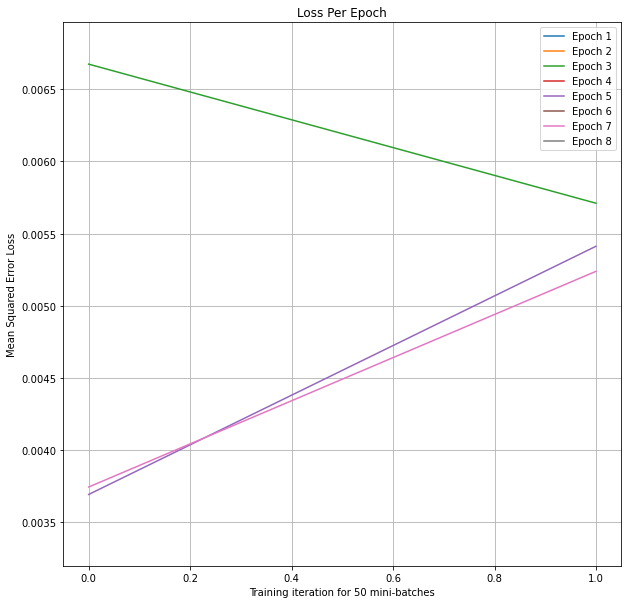

In [94]:
plt.figure(figsize=(10,10))
plt.clf()

for i in range(1, len(epoch_history)):
    plt.plot(range(len(epoch_history[f'{i}'])), epoch_history[f'{i}'], label=f'Epoch {i}')

plt.legend(loc="upper right")
plt.xlabel(f'Training iteration for {num_mini_batch_print} mini-batches')
plt.ylabel('Mean Squared Error Loss')
plt.title('Loss Per Epoch')
plt.grid(True)
plt.savefig('Epoch_loss_transfer_NCD.png')
plt.show()

In [95]:
PATH = './transfer.pth'
torch.save(new_model.state_dict(), PATH)

In [97]:
output_dir = './transfer_output'
os.makedirs(output_dir,exist_ok=True)

output_list = []

test_loss = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images_gray, images_color, images_ab = data[0].to(device), data[1].to(device), data[2].to(device)
        outputs = new_model(images_gray)
        outputs_color = cat_l_ab(images_gray, outputs)
        outputs_lab = torch.cat((images_gray, outputs), 1)
        rgb_outputs = tensor_to_rgb(outputs_color.cpu())
        
        
        for j in range(outputs.shape[0]):
            loss = criterion(outputs[j], images_ab[j])
            test_loss.append(loss)
            img_idx = (i * batch_size) + j
            img_path = os.path.join(output_dir, transform_test.image_paths[img_idx])
            img_data = torch.permute(rgb_outputs[j], (1, 2, 0)).numpy()
            output_list.append(img_data)
            io.imsave(img_path, img_data)
            
print('Avg Test loss :-',torch.mean(torch.tensor(test_loss)))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Avg Test loss :- tensor(0.0046)


#### Images Plots for NCD Dataset

Target: Original Color NCD Image


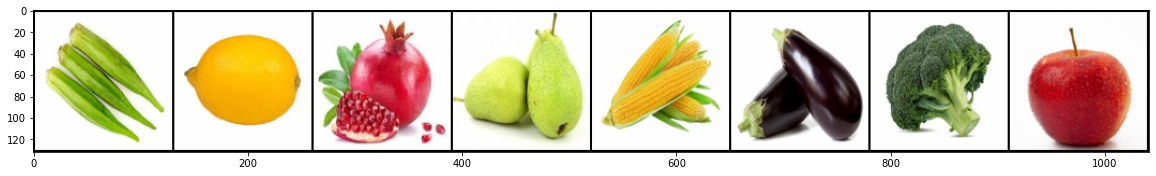

Input Image: Gray NCD Image


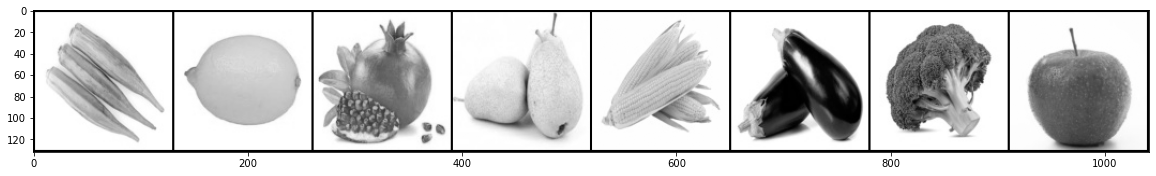

LAB NCD Image


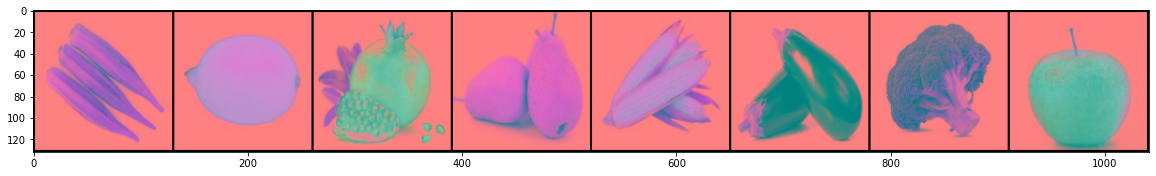

Predicted Colorized NCD Image


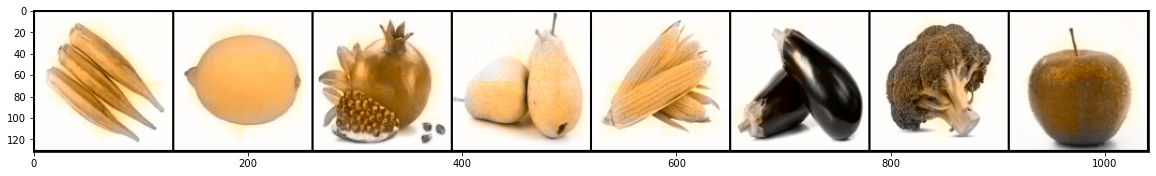

In [98]:
dataiter = iter(test_loader)
images_gray, images_color, images_ab = dataiter.next()

print('Target: Original Color NCD Image')
imshow(torchvision.utils.make_grid(tensor_to_rgb(images_color)))

print('Input Image: Gray NCD Image')
imshow(torchvision.utils.make_grid(images_gray))

print('LAB NCD Image')
imshow(torchvision.utils.make_grid(images_color))

print('Predicted Colorized NCD Image')
image_tensor = []
for i in range(8):
    image_tensor.append(transform(output_list[i]))
imshow(torchvision.utils.make_grid(image_tensor))